In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import ensemble
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk as nltk
from nltk.corpus import inaugural, stopwords
from nltk.corpus import PlaintextCorpusReader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Description and Purpose of Assignment

The purpose of this assignment is to apply the methods learned in Unit 4.

The assignment is to analyze and compare text from 10 different authors that share a relationship with one another. For this assignment we will be analyzing Innaguration speaches from 10 different US presidents who held office for two terms. 

The part of the assignment is to use analyze the text of these authors and use the clustering techniques learned in Unit 4 to create a series of clusters. We will try a number of clustering techniques and pick the one we think best represents your data. We will then see if the authors are consistently grouped into the same cluster.

Next, we will perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features we will build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to our holdout group and see if our clustering on those members perform as you'd expected. If there is a divergence in the relative stability of your model and your clusters, we will delve into why.

# Description of the Corpus 

For this assignment I chose to use the innaugartion speeches in the NLTK corpus. I chose ten innaguartion speeches from the past ten presidents that held atleast two terms in office. I chose to use each of these president's speech from their first innauguration. 

# Cleaning the Data

In [2]:
# Load the speaches I want to analyze

obama = inaugural.raw('2009-Obama.txt')
bush = inaugural.raw('2001-Bush.txt')
clinton = inaugural.raw('1993-Clinton.txt')
reagan = inaugural.raw('1981-Reagan.txt')
nixon = inaugural.raw('1969-Nixon.txt')
eisenhower = inaugural.raw('1953-Eisenhower.txt')
roosevelt = inaugural.raw('1933-Roosevelt.txt')
wilson = inaugural.raw('1913-Wilson.txt')
mckinley = inaugural.raw('1897-McKinley.txt')
cleveland = inaugural.raw( '1885-Cleveland.txt')

In [3]:
# Remove newlines and other extra whitespace by splitting and rejoining.
obama = ' '.join(obama.split())
bush = ' '.join(bush.split())
clinton = ' '.join(clinton.split())
reagan = ' '.join(reagan.split())
nixon = ' '.join(nixon.split())
eisenhower = ' '.join(eisenhower.split())
roosevelt = ' '.join(roosevelt.split())
wilson = ' '.join(wilson.split())
mckinley = ' '.join(mckinley.split())
cleveland = ' '.join(cleveland.split())


In [4]:
#Create text cleaner function
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [5]:
# clean the speechs
obama = text_cleaner(obama)
bush = text_cleaner(bush)
clinton  = text_cleaner(clinton)
reagan = text_cleaner(reagan)
nixon = text_cleaner(nixon)
eisenhower = text_cleaner(eisenhower)
roosevelt = text_cleaner(roosevelt)
wilson = text_cleaner(wilson)
mckinley = text_cleaner(mckinley)
cleveland = text_cleaner(cleveland)

In [7]:
#Load spacy and use it to clean and process the data
nlp = spacy.load("en_core_web_sm")

# All the processing work is done here, so it may take a while.
obama_doc = nlp(obama)
bush_doc = nlp(bush)
clinton_doc = nlp(clinton)
reagan_doc = nlp(reagan)
nixon_doc = nlp(nixon)
eisenhower_doc = nlp(eisenhower)
roosevelt_doc = nlp(roosevelt)
wilson_doc = nlp(wilson)
mckinley_doc = nlp(mckinley)
cleveland_doc = nlp(cleveland)

In [8]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
sentences = []
for sentence in obama_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
for sentence in bush_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
for sentence in clinton_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

for sentence in reagan_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
for sentence in nixon_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

for sentence in eisenhower_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
for sentence in roosevelt_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)

for sentence in wilson_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
for sentence in mckinley_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)
    
    
for sentence in cleveland_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)


print(sentences[20])
print('We have {} sentences'.format(len(sentences)))

['day', 'gather', 'choose', 'hope', 'fear', 'unity', 'purpose', 'conflict', 'discord']
We have 982 sentences


# Building the Model

In [9]:
obama_sents  = [[str(sent), "Obama"] for sent in obama_doc.sents]
bush_sents = [[str(sent), "Bush"] for sent in bush_doc.sents]
clinton_sents = [[str(sent), "Clinton"] for sent in clinton_doc.sents]
reagan_sents  = [[str(sent), "Reagan"] for sent in reagan_doc.sents]
nixon_sents = [[str(sent), "Nixon"] for sent in nixon_doc.sents]
eisenhower_sents = [[str(sent), "Eisenhower"] for sent in eisenhower_doc.sents]
roosevelt_sents = [[str(sent), "Roosevelt"] for sent in roosevelt_doc.sents]
wilson_sents = [[str(sent), "Wilson"] for sent in wilson_doc.sents]
mckinley_sents = [[str(sent), "Mckinley"] for sent in mckinley_doc.sents]
cleveland_sents = [[str(sent), "Cleveland"] for sent in cleveland_doc.sents]

In [10]:
# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(obama_sents + bush_sents + clinton_sents
                        + reagan_sents + nixon_sents + eisenhower_sents
                        + roosevelt_sents + wilson_sents + mckinley_sents
                        + cleveland_sents)
sentences.head()

,0,1
0,my fellow citizens: i stand here today humbled...,Obama
1,i thank president bush for his service to our ...,Obama
2,forty-four americans have now taken the presid...,Obama
3,the words have been spoken during rising tides...,Obama
4,"yet, every so often the oath is taken amidst g...",Obama


In [11]:
sentences = sentences.rename({0:'sentence', 1:'author'}, axis=1)
sentences.head()

,sentence,author
0,my fellow citizens: i stand here today humbled...,Obama
1,i thank president bush for his service to our ...,Obama
2,forty-four americans have now taken the presid...,Obama
3,the words have been spoken during rising tides...,Obama
4,"yet, every so often the oath is taken amidst g...",Obama


In [12]:
# Use Train Test Split to test the model on 75% of the data and creating a holdout group of 25%. 
from sklearn.model_selection import train_test_split
X = sentences.sentence
y = sentences.author
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=3)



In [13]:
# Use the TFIDF Vectorizer to transform the text
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(X_train)
text = tfidf.transform(X_train)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


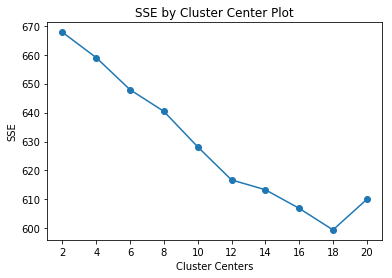

In [14]:
#Create a function using MiniBatchKmeans to determine the optimal amount of Clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1000, batch_size=250, random_state=22).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

Using the Find_Optimal_Clusters function we created, we can see that the optimal number of clusters for our expirment is 18.


In [15]:
clusters = MiniBatchKMeans(n_clusters=18, init_size=1000, batch_size=250, random_state=22).fit_predict(text)

In [16]:
#Create a Dataframe of the X train and Y train data. 

sentences_train = pd.DataFrame(columns = ['Sentence', 'Author'])

sentences_train['Sentence'] = X_train
sentences_train['Author'] = y_train
sentences_train.head()

,Sentence,Author
726,we aim at the assurance of a rounded and perma...,Roosevelt
161,"we will build our defenses beyond challenge, l...",Bush
277,now we must do the work the season demands.,Clinton
87,"for as much as government can do and must do, ...",Obama
193,what you do is as important as anything govern...,Bush


In [17]:
# Match the Sentences and Author to the corresponding clusters

idea={'Sentence':list(sentences_train['Sentence']), 'Author':list(sentences_train['Author']),'Cluster':clusters} #Creating dict having doc with the corresponding cluster number.
frame=pd.DataFrame(idea, columns=['Sentence', 'Author', 'Cluster']) # Converting it into a dataframe.

print("Sentence, Author and Cluster")
frame.head(20) #Print the doc with the labeled cluster number.


Sentence, Author and Cluster


,Sentence,Author,Cluster
0,we aim at the assurance of a rounded and perma...,Roosevelt,12
1,"we will build our defenses beyond challenge, l...",Bush,8
2,now we must do the work the season demands.,Clinton,8
3,"for as much as government can do and must do, ...",Obama,1
4,what you do is as important as anything govern...,Bush,1
5,"and though it requires sacrifice, it brings a ...",Bush,8
6,"equally, we need for these same farms and fact...",Eisenhower,8
7,freedom and the dignity of the individual have...,Reagan,8
8,can we solve the problems confronting us?,Reagan,8
9,we will strive to listen in new ways to the vo...,Nixon,8


In [22]:
#Find out how many sentences are in each cluster
print("Number of Sentences Per Cluster")
print(frame['Cluster'].value_counts()) #Print the counts of doc belonging to each cluster

Number of Sentences Per Cluster
8     263
4      59
7      44
1      39
0      34
6      32
3      30
15     30
17     29
13     28
5      26
9      23
16     21
10     20
2      19
12     18
14     12
11      9
Name: Cluster, dtype: int64


## Observation

As we can see, the majority of the sentences (263) are classified in cluster 8. The remaining 17 clusters contain between 9 and 59 sentences.

# Plotting the Clusters

Now we will use PCA andd TSNE to plot the clusters.

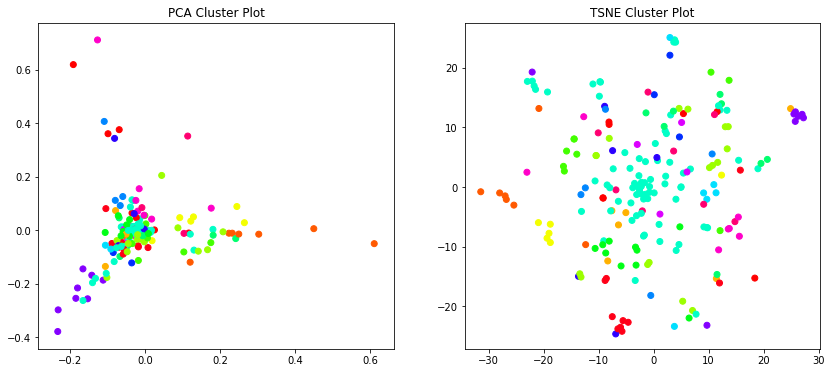

In [19]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=500, replace=False)
    
    pca = PCA(n_components=18).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=18).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=200, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

Next let's look at the contents of each cluster andd what words each cluster contains. 

In [22]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
moment,freedom,promise,nation,ideals,failure,american,common,life,duty

Cluster 1
currency,balance,best,credit,federal,public,form,present,people,government

Cluster 2
know,love,hopes,fail,moment,nation,thank,earth,bless,god

Cluster 3
believe,unity,small,live,means,great,century,history,government,time

Cluster 4
freedom,love,policy,does,change,power,people,country,history,world

Cluster 5
americans,renewal,question,act,celebrate,american,people,new,helped,today

Cluster 6
new,cause,dignity,father,strength,rights,fathers,faith,laws,man

Cluster 7
new,society,action,demands,meet,revenue,public,people,congress,shall

Cluster 8
answer,good,act,peace,freedom,spirit,believe,nation,americans,work

Cluster 9
hold,shall,strength,unity,faith,peoples,world,economic,men,free

Cluster 10
people,peoples,order,freedom,seek,nation,life,faith,hope,way

Cluster 11
possible,justice,hands,chief,americans,citizens,session,fellow,congress,president

Cluster 12
courage,suffer,need,people,comes,v

We can see that some of the clusters contain words that appear in other clusters. The cluster that contains the most sentences is Cluster 8. 

Cluster 8
answer,good,act,peace,freedom,spirit,believe,nation,americans,work

# Author, Sentences and Cluster

Lets look at which authors sentences fell into which cluster.

In [25]:
df = frame.loc[frame['Author']=='Obama']
df['Cluster'].value_counts()

8     38
4      7
17     6
13     5
2      5
7      4
3      4
0      4
10     3
6      3
5      3
16     1
9      1
1      1
Name: Cluster, dtype: int64

In [26]:
df = frame.loc[frame['Author']=='Bush']
df['Cluster'].value_counts()

8     24
0      8
13     7
4      6
16     4
6      4
3      4
17     2
14     2
10     2
7      2
5      2
2      2
1      2
15     1
12     1
Name: Cluster, dtype: int64

In [27]:
df = frame.loc[frame['Author']=='Clinton']
df['Cluster'].value_counts()

8     18
13     9
5      7
4      5
17     4
3      4
10     3
16     2
11     2
0      2
15     1
12     1
2      1
1      1
Name: Cluster, dtype: int64

In [28]:
df = frame.loc[frame['Author']=='Reagan']
df['Cluster'].value_counts()

8     44
1      8
3      5
12     5
6      5
4      4
5      4
16     3
2      3
17     3
10     3
13     3
7      2
9      2
11     2
14     2
0      2
15     1
Name: Cluster, dtype: int64

In [29]:
df = frame.loc[frame['Author']=='Nixon']
df['Cluster'].value_counts()

8     24
17    11
4      9
6      6
13     4
12     4
2      4
7      3
3      3
5      2
1      2
0      2
15     1
11     1
9      1
Name: Cluster, dtype: int64

In [30]:
df = frame.loc[frame['Author']=='Eisenhower']
df['Cluster'].value_counts()

8     29
9     15
4     11
6      8
10     6
7      5
0      5
3      3
2      3
16     2
14     2
15     1
5      1
Name: Cluster, dtype: int64

In [31]:
df = frame.loc[frame['Author']=='Roosevelt']
df['Cluster'].value_counts()

8     31
12     4
7      4
5      4
16     3
15     3
4      3
3      3
0      3
10     2
17     1
14     1
9      1
1      1
Name: Cluster, dtype: int64

In [32]:
df = frame.loc[frame['Author']=='Wilson']
df['Cluster'].value_counts()

8     19
15    10
1      4
0      4
9      2
7      2
6      2
17     1
14     1
12     1
11     1
10     1
5      1
4      1
2      1
Name: Cluster, dtype: int64

In [33]:
df = frame.loc[frame['Author']=='Mckinley']
df['Cluster'].value_counts()

8     24
7     18
1     12
15    11
4     11
14     4
3      4
0      4
16     3
11     3
6      3
12     1
9      1
5      1
Name: Cluster, dtype: int64

In [34]:
df = frame.loc[frame['Author']=='Cleveland']
df['Cluster'].value_counts()

8     12
1      8
7      4
16     3
4      2
17     1
15     1
12     1
6      1
5      1
Name: Cluster, dtype: int64

There is no suprise that most author's sentences fell into cluster 8.

# Back to the Holdout Group

Now lets apply the Tfifd Vectorizer and Clustering to our Holdout group and see if we get similar groupings and words in our clusters. 

In [29]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(X_train)
text_train = tfidf.transform(X_train)

In [30]:
clusters = MiniBatchKMeans(n_clusters=18, init_size=1000, batch_size=250, random_state=22).fit(text_train)

In [38]:
tfidf_test = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf_test.fit(X_test)
text_test = tfidf.transform(X_test)

In [39]:
clusters.predict(text_test)

array([ 8,  9,  8,  3,  4,  8,  8,  8,  8, 12,  9,  4,  3, 15,  4, 13,  1,
       16,  8,  1,  3,  4, 13,  8,  8,  8, 17,  2,  8,  4, 14,  4,  8,  2,
       13,  8,  4,  7,  1, 11, 13,  1,  8,  8,  4,  8,  0,  8, 15, 16,  8,
        4, 13,  3,  8,  5,  8,  8,  8,  8,  8, 10,  8,  8,  7,  0, 17,  8,
       13,  0,  8,  8, 12,  1,  3,  8, 17, 17, 17,  1,  6,  8,  5,  8,  5,
        6,  1,  0,  8,  1,  8, 17,  8,  0,  8, 14,  1,  7, 16, 15, 13,  4,
        8,  8,  8,  8,  0,  3, 13,  4,  8,  8,  7,  4, 13,  8,  8,  7,  2,
       11, 15,  8,  8,  8,  8,  8,  8, 16,  8, 16,  8,  8, 13,  8,  4,  8,
       15,  3,  0,  8,  8,  1,  7,  8, 15, 16,  8,  8,  8, 14,  8,  7,  1,
        5, 13,  1,  8,  8, 17,  1,  8,  8, 13,  0, 11,  3, 16,  9,  0,  8,
        4,  0,  8,  8,  9,  2, 12,  8,  8,  0, 11,  4,  8,  0,  6,  8,  8,
        8, 13,  8, 13,  8,  8, 16,  8,  2, 15,  8,  8,  8,  8,  8,  8,  1,
        0,  3,  8,  8,  8,  6,  7, 11,  7,  8,  8,  8,  0,  0, 10,  4,  4,
       14,  8,  8,  8,  4

In [40]:
sentences_test = pd.DataFrame(columns = ['Sentence', 'Author'])
sentences_test['Sentence'] = X_test
sentences_test['Author'] = y_test

In [41]:
idea2={'Sentence':list(sentences_test['Sentence']), 'Author':list(sentences_test['Author']),'Cluster':
      clusters.predict(text_test)} #Creating dict having doc with the corresponding cluster number.
frame2=pd.DataFrame(idea2, columns=['Sentence', 'Author', 'Cluster']) # Converting it into a dataframe.

print("Sentence, Author and Cluster")
frame2.head(20) #Print the doc with the labeled cluster number.


Sentence, Author and Cluster


,Sentence,Author,Cluster
0,recall that earlier generations faced down fas...,Obama,8
1,they tutor men in treason.,Eisenhower,9
2,"in the light of this principle, we stand ready...",Eisenhower,8
3,"for our own country, it has been a time of rec...",Eisenhower,3
4,by your gracious cooperation in the transition...,Reagan,4
5,they know only the rules of a generation of se...,Roosevelt,8
6,it knows no sectional boundaries or ethnic and...,Reagan,8
7,are we nearing the light a day of freedom and ...,Eisenhower,8
8,"rather, it has been the risk-takers, the doers...",Obama,8
9,it can be helped by national planning for and ...,Roosevelt,12


In [42]:
print("Number of Sentences Per Cluster")
print(frame2['Cluster'].value_counts()) #Print the counts of doc belonging to each cluster

Number of Sentences Per Cluster
8     104
4      22
0      15
13     14
1      14
7      10
3       9
16      8
15      8
17      7
11      6
2       6
5       5
14      4
12      4
9       4
6       4
10      2
Name: Cluster, dtype: int64


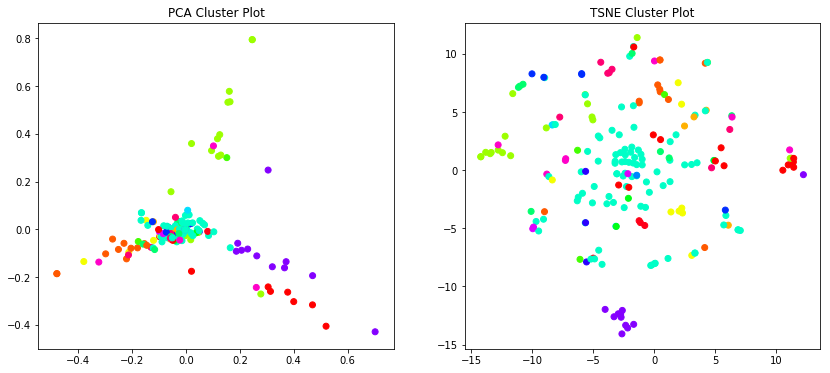

In [43]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=200, replace=False)
    
    pca = PCA(n_components=18).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=18).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=200, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text_test, clusters.predict(text_test))

In [44]:
clusters2 = clusters.predict(text_test)
def get_top_keywords(data, clusters2, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters2).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text_test, clusters2, tfidf.get_feature_names(), 10)


Cluster 0
failure,comes,home,vision,moment,duty,common,interests,american,life

Cluster 1
greater,present,currency,continue,crisis,provide,years,support,people,government

Cluster 2
act,service,nation,things,citizen,concern,thank,ask,oath,god

Cluster 3
courage,look,trust,future,opportunity,return,trial,speak,government,time

Cluster 4
nations,nation,need,century,greater,new,power,know,country,world

Cluster 5
question,ask,care,old,america,order,earth,hope,crisis,today

Cluster 6
man,american,better,labor,greatest,constant,fathers,children,cause,laws

Cluster 7
public,united,states,spirit,necessity,leaders,congress,revenue,people,shall

Cluster 8
new,peace,just,long,service,use,seek,come,nation,economy

Cluster 9
place,cause,firm,citizen,children,policy,foreign,set,men,free

Cluster 10
fathers,father,far,faithful,faith,federal,forward,years,long,way

Cluster 11
know,begin,constitution,spirit,nation,citizens,fellow,service,thank,president

Cluster 12
essential,old,action,simple,oath,or

# Write Up

As we can see, although the clusters in the test and train group sometimes contain the same, overall the test and train groups clusters are not similar to one another. However, it is interesting that in both the test and the train group most sentences were grouped into cluster eight, even though cluster eight was different for the test and the train group. 

Overall, I do not believe our model is strong enough to correctly identify the author of a given speech based on the content of the speech. The are two main reasons for this. 

First, because the speaches were only 90-120 sentences long, there was not enough text to give the model enough data to train on. A better way would have to loaded all the writings of these presidents and used that for model. The larger corpus would give more information for the model to analyze and work with.

Second, because these were all innaguration speeches they are on the same subject and contained almost identical themes and subject matter. Because of this it is hard to distinguish one author from the other. For instance, if I used all the commencement speaches at Ivy League colleges over the past 10 years it would also be difficult to train a model to determine the author as these also contain similar themes, subject matter, and audience. 

# Next Steps

Although this experiment did not perform well at determining which author wrote which speach, the model itself should work probably if given more information. For future explorations, I would give it a larger corpus to analyze, such as literary works from 10 different authors. 
